In [16]:
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import string
import pickle
import tqdm

import scipy.stats

#extend notebook
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container {width:99.5% !important;} </style>"))
%config Completer.use_jedi = False

#for Bayesian analysis
import arviz as az

/tmp/ipykernel_61745/1301145004.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# <span style="font-family:calibri; font-weight:bold; font-size:1.4em;">Functions</span><a class="anchor" id="functions"></a>

In [2]:
#Overall definitions of a figure style we use.
def stdfigsize(scale=1.0, nrows=1, ncols=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.

    Parameters
    ----------
    scale: float
           Relationship between the size of the labels 
           and the size of the plot itself. Scales < 1
           favor the labels and vice-versa. 
           (Default: 1.)
    nrows: int
           Number of rows. (Default: 1)
    ncols: int
           Number of columns. (Default: 1)
    ratio: float
           Ratio between the horizontal and vertical 
           lengths of a figure. Default: 1.3.
    ----------
    Returns (7*ratio*scale*nrows, 7.*scale*ncols).
    """
    return((7*ratio*scale*ncols, 7.*scale*nrows))


sns.set_style("white")
sns.set_style({"xtick.direction": "out", "ytick.direction": "out"})

rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'], #Helvetica must be installed for this to work
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': stdfigsize(),
    'lines.linewidth': 3
}
mpl.rcParams.update(rcparams)

In [3]:
def scipy_kde(data, nbins=150, log=False, symmetrical=False, bw_method=None):
    """
    Evaluates the kde from a np.array via scipy.stats.gaussian_kde.

    Parameters
    ----------
    data: array 
          Array of data for which one 
          wishes to estimate a distribution.
    nbins: int
           Number of bins used in the estimation process.
           (Default: 150).
    log: bool
         True for logspaced bins. (Default: False).
    symmetrical: bool
                 True for symmetrical bin interval.
                 (Default: False).
    bw_method: bandwidth method. (Default: None).
    ----------
    Returns a list containing two arrays, in the 
    form [bins, kde].
    """
    if log:
        if symmetrical:
            maxdata = max(np.abs(np.min(data)), np.abs(np.max(data)))
            bins = np.logspace(-maxdata, maxdata, nbins)
        else:
            bins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), nbins)
    else:
        if symmetrical:
            maxdata = max(np.abs(np.min(data)), np.abs(np.max(data)))
            bins = np.linspace(-maxdata, maxdata, nbins)
        else:
            bins = np.linspace(np.min(data), np.max(data), nbins)
            
    gkde = scipy.stats.gaussian_kde(data, bw_method)
    
    return (np.transpose([bins, gkde(bins)]))


def KDE_function(data, loc='median', nbins=1000, drange=False, lowpercent=2.5, highpercent=97.5):
    """
    Fits a Gaussian kernel to data to estimate 
    a probability density function. (Basically a 
    wrapper to scipy.stats.gaussian_kde().)
    
    Parameters
    ----------
    data: array 
          A 1d iterable object containing floating numbers
          for which one wishes to estimate a distribution.
    loc: str
         Either 'median' or 'mean'. (Default: 'median').
    nbins: int
          Number of bins used to estimate the kernel.         
          (Default: 1000)
    drange: bool
            Whether to return the 2.5 (lowpercent) and 
            97.5 (highpercent) percentiles (that is, a 
            95% data window). (Default: False)
    lowpercent: float
                Lowest specified percentile of data.
                (Default: 2.5%).
    highpercent: float
                 Highest specified percentile of data.
                 (Default: 97.5%).
    ----------
    Returns a tuple of arrays containing x, pdf(x), 
    xmedian, ymedian and, possibly, the two percentiles
    of the data.
    """
    if loc=='median':
        if drange==False:
            x, y       = scipy_kde(data, nbins=nbins).T
            median_    = np.median(data)
            idx_median = np.abs(x-median_).argmin()
            
            return x, y, median_, y[idx_median]

        else:
            x, y       = scipy_kde(data, nbins=nbins).T
            median_    = np.median(data)
            min_       = np.percentile(data, lowpercent, interpolation='nearest')
            max_       = np.percentile(data, highpercent, interpolation='nearest')
            idx_median = np.abs(x-median_).argmin()

            return x, y, median_, y[idx_median], min_, max_
        
    else: #'mean'
        if drange==False:
            x, y     = scipy_kde(data, nbins=nbins).T
            mean_    = np.mean(data)
            idx_mean = np.abs(x-mean_).argmin()
            
            return x, y, mean_, y[idx_mean]

        else:
            x, y       = scipy_kde(data, nbins=nbins).T
            mean_      = np.mean(data)
            idx_mean   = np.abs(x-mean_).argmin()
            min_       = np.percentile(data, lowpercent, interpolation='nearest')
            max_       = np.percentile(data, highpercent, interpolation='nearest')

            return x, y, mean_, y[idx_mean], min_, max_

In [4]:
def KDE_organised_significant(first_kdes, second_kdes=None, names='', freq=100, start=0, end=0, top=3, by='first', significance=None, means=None):
    """
    Takes an array of posterior probability
    distributions and organises them so
    we can plot Fig. 3.
    
    Parameters
    ----------
    first_kdes: array (iterable) 
                Kernel density data.
    second_kdes: array (iterable) 
                 Kernel density data.
    names: tuple, list, array
           Names of cryptos corresponding to 
           kernel data.
    freq: int
          Sampling frequency of array of KDE's to plot.
    start: int
           Avoids first KDEs if mean values are too large.
    end: int
         Avoids last KDEs if mean values are too large.
    top: int
         Number of top cryptos to add to the analysis.
    by: str, array
        Either "first", "second" or an array with names.
        Way to organise the KDEs by the first array, the 
        second or by a list of names.
    significance: array
        Boolean array about a significance effect of a 
        predictor.
    means: array
           Empirical means of posterior distributions
           of regression coeficients. 
    ----------
    Returns two arrays, the x and pdf(x) of posterior 
    distributions of coefficients organised 
    by their mean values.
    """
    def sort_two_arrays(first_kdes, second_kdes, freq, start, end, top):
        """
        
        Parameters
        ----------
        first_kdes: iterable 
                    Kernel density data.
        second_kdes: iterable 
                     Kernel density data.
        names: iterable
               Names of coins.
        freq: int
              Sampling frequency of array of KDE's to plot.
        start: int
               Avoids first KDE's if means values are too large.
        end: int
             Avoids last KDE's if means values are too large.
        top: int
             Numbers of top coins to add to the analysis.
        ----------
        Returns
        """
        x, y               = np.asarray(second_kdes)[::,0], np.asarray(second_kdes)[::,1]
        top3x, top3y       = x[:top], y[:top]

        xuni, yuni         = np.asarray(first_kdes)[::,0], np.asarray(first_kdes)[::,1]
        top3xuni, top3yuni = xuni[:top], yuni[:top]

        #sampling coins from the simpler model
        sortxuni           = np.argsort(scipy.integrate.trapezoid(xuni*yuni, xuni))[::-1]
        xsampuni, ysampuni = xuni[sortxuni], yuni[sortxuni]
        xsamp, ysamp       = x[sortxuni], y[sortxuni]

        end                = len(xsamp)-end
        xsampuni, ysampuni = xsampuni[::freq][start:end], ysampuni[::freq][start:end]
        xsamp, ysamp       = xsamp[::freq][start:end], ysamp[::freq][start:end]

        sampled_coins      = np.concatenate((np.asarray(names)[sortxuni][::freq][start:end], names[:top])) #applying the first sort to sample coins and join them to the top coins.

        #joining the sampled coins + top coins
        xuni, yuni         = np.concatenate((xsampuni, top3xuni)), np.concatenate((ysampuni, top3yuni)) 
        sortxuni           = np.argsort(scipy.integrate.trapezoid(xuni*yuni, xuni))[::-1] #need to sort again: the sampled coins and the top 
        xsampuni, ysampuni = xuni[sortxuni], yuni[sortxuni]

        x, y               = np.concatenate((xsamp, top3x)), np.concatenate((ysamp, top3y)) 
        xsamp, ysamp       = x[sortxuni], y[sortxuni]

        sampled_coins      = sampled_coins[sortxuni]
        
        return xsampuni, ysampuni, xsamp, ysamp, sampled_coins
#########################################
        
    if type(names)==str:
        names = ['']*len(first_kdes)
    else: pass
                
    if type(second_kdes) == type(None):
        
        x, y               = np.asarray(first_kdes)[::,0], np.asarray(first_kdes)[::,1]
        top3x, top3y       = x[:top], y[:top]

        sortx              = np.argsort(scipy.integrate.trapezoid(x*y, x))[::-1]
        xsamp, ysamp       = x[sortx], y[sortx]
        end                = len(xsamp)-end
        xsamp, ysamp       = xsamp[::freq][start:end], ysamp[::freq][start:end]

        if type(significance)==type(None) and type(means)==type(None):
            sampled_coins      = np.concatenate((np.asarray(names)[sortx][::freq][start:end], names[:top]))
        else:
            sampled_coins      = np.concatenate((np.asarray(names)[sortx][::freq][start:end], names[:top]))
            significance       = np.concatenate((np.asarray(significance)[sortx][::freq][start:end], significance[:top]))
            means              = np.concatenate((np.asarray(means)[sortx][::freq][start:end], means[:top]))

        x, y         = np.concatenate((xsamp, top3x)), np.concatenate((ysamp, top3y)) 
        sortx        = np.argsort(scipy.integrate.trapezoid(x*y, x))[::-1] #need to sort again: the sampled coins and the top 
        xsamp, ysamp = x[sortx], y[sortx]

        if type(significance)==type(None) and type(means)==type(None):
            sampled_coins      = sampled_coins[sortx]

            return xsamp, ysamp, sampled_coins
        else:
            sampled_coins      = sampled_coins[sortx]
            significance       = significance[sortx]
            means              = means[sortx]

            return xsamp, ysamp, sampled_coins, significance, means
                        
    else:
        if not type(by)==str: #if we pass an array with names            
            order = [np.argwhere(names_list==coin_)[0][0] for coin_ in by]
            
            by                 = names_list[order]
            first_kdes         = first_kdes[order]
            second_kdes        = second_kdes[order]
            
            x, y               = np.asarray(second_kdes)[::,0], np.asarray(second_kdes)[::,1]
            top3x, top3y       = x[:top], y[:top]
            xuni, yuni         = np.asarray(first_kdes)[::,0], np.asarray(first_kdes)[::,1]
            top3xuni, top3yuni = xuni[:top], yuni[:top]
            
            end                = len(x)-end
            xsampuni, ysampuni = xuni[::freq][start:end], yuni[::freq][start:end]
            xsamp, ysamp       = x[::freq][start:end]   , y[::freq][start:end]
            sampled_coins      = by[::freq][start:end]
 
            return xsampuni, ysampuni, xsamp, ysamp, sampled_coins

        elif by=='second': 
            temp        = first_kdes
            first_kdes  = second_kdes
            second_kdes = temp
            
            xsamp, ysamp, xsampuni, ysampuni, sampled_coins = sort_two_arrays(first_kdes, second_kdes, freq, start, end, top) 
            
            return xsamp, ysamp, xsampuni, ysampuni, sampled_coins
            
        else: #by='first'
            return sort_two_arrays(first_kdes, second_kdes, freq, start, end, top) #xsampuni, ysampuni, xsamp, ysamp, sampled_coins

In [5]:
def save_obj(obj, name):
    '''
    Takes an object and stores it as a pickle file 'name.pkl'

    input:
        * obj - object, object to be stored
        * name - str, filename
    output:
        
    '''
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    '''
    Loads a pickle file 'name.pkl'

    input:
        * name - str, filename
    output:
        * file - obj, object stored in file
    '''
    with open(name, 'rb') as f:
        return pickle.load(f)

In [6]:
def significant_EFFECT(row_):
    """
    Boolean function to evaluate whether zero is 
    inside hdi of the posterior probability distribution 
    estimated for a linear coefficient in a Bayesian 
    hierarchical model.
    
    Parameters
    ----------
    row_: row of a pd.Dataframe object containing the
          summary for a hierarchical model's 
          coefficients.
    ----------
    Returns a boolean.
    """
    a, b = row_['hdi_3%'], row_['hdi_97%']
    
    if a>0 and b>0:
        return True
    elif a<0 and b<0:
        return True
    else:
        return False

# <span style="font-family:calibri; font-weight:bold; font-size:1.4em;">Data Loading</span><a class="anchor" id="loading"></a>

In [7]:
all_goodness_clean         = pd.read_pickle('../goodness-and-distr-analysis/data/all_goodness_clean.pkl')

In [8]:
summary_trace_pos_cap_time = load_obj('data/summary_trace_pos_cap_time.pkl')
summary_trace_neg_cap_time = load_obj('data/summary_trace_neg_cap_time.pkl')

kde_pos_cap_time_b         = load_obj('data/kde_pos_cap_time_b.pkl')
kde_neg_cap_time_b         = load_obj('data/kde_neg_cap_time_b.pkl')

kde_pos_cap_time_c         = load_obj('data/kde_pos_cap_time_c.pkl')
kde_neg_cap_time_c         = load_obj('data/kde_neg_cap_time_c.pkl')

coin_positive              = load_obj('data/coin_pos.pkl')
coin_negative              = load_obj('data/coin_neg.pkl')

coin_lookup_pos            = load_obj('data/coin_lookup_pos.pkl') 
coin_lookup_neg            = load_obj('data/coin_lookup_neg.pkl') 

# <span style="font-family:calibri; font-weight:bold; font-size:1.4em;">Figure 3</span><a class="anchor" id="fig3"></a>

In [9]:
#Masks to filter market cap or market age coefficients;
Cmaskcaptime = ~(np.char.find(summary_trace_neg_cap_time.index.values.astype(str), 'c[')==-1)
Bmaskcaptime = ~(np.char.find(summary_trace_neg_cap_time.index.values.astype(str), 'b[')==-1)

Cposmaskcaptime = ~(np.char.find(summary_trace_pos_cap_time.index.values.astype(str), 'c[')==-1)
Bposmaskcaptime = ~(np.char.find(summary_trace_pos_cap_time.index.values.astype(str), 'b[')==-1)

In [10]:
Bsigcaptime    = summary_trace_neg_cap_time[Bmaskcaptime].apply(significant_EFFECT, axis=1).values
Bpossigcaptime = summary_trace_pos_cap_time[Bposmaskcaptime].apply(significant_EFFECT, axis=1).values

Csigcaptime    = summary_trace_neg_cap_time[Cmaskcaptime].apply(significant_EFFECT, axis=1).values
Cpossigcaptime = summary_trace_pos_cap_time[Cposmaskcaptime].apply(significant_EFFECT, axis=1).values

In [11]:
posnames = []
selected_coins_and_tickers = np.load('data/selected_coins_and_tickers.npy')
all_slugs                  = np.load('data/selected_coins_and_tickers.npy')
for slug_ in list(coin_lookup_pos.keys()):
    idx       = np.argwhere(all_slugs==slug_).flatten()[0]
    posnames += [selected_coins_and_tickers[idx][0]]

negnames = []
selected_coins_and_tickers = np.load('data/selected_coins_and_tickers.npy')
all_slugs                  = np.load('data/selected_coins_and_tickers.npy')
for slug_ in list(coin_lookup_neg.keys()):
    idx       = np.argwhere(all_slugs==slug_).flatten()[0]
    negnames += [selected_coins_and_tickers[idx][0]]

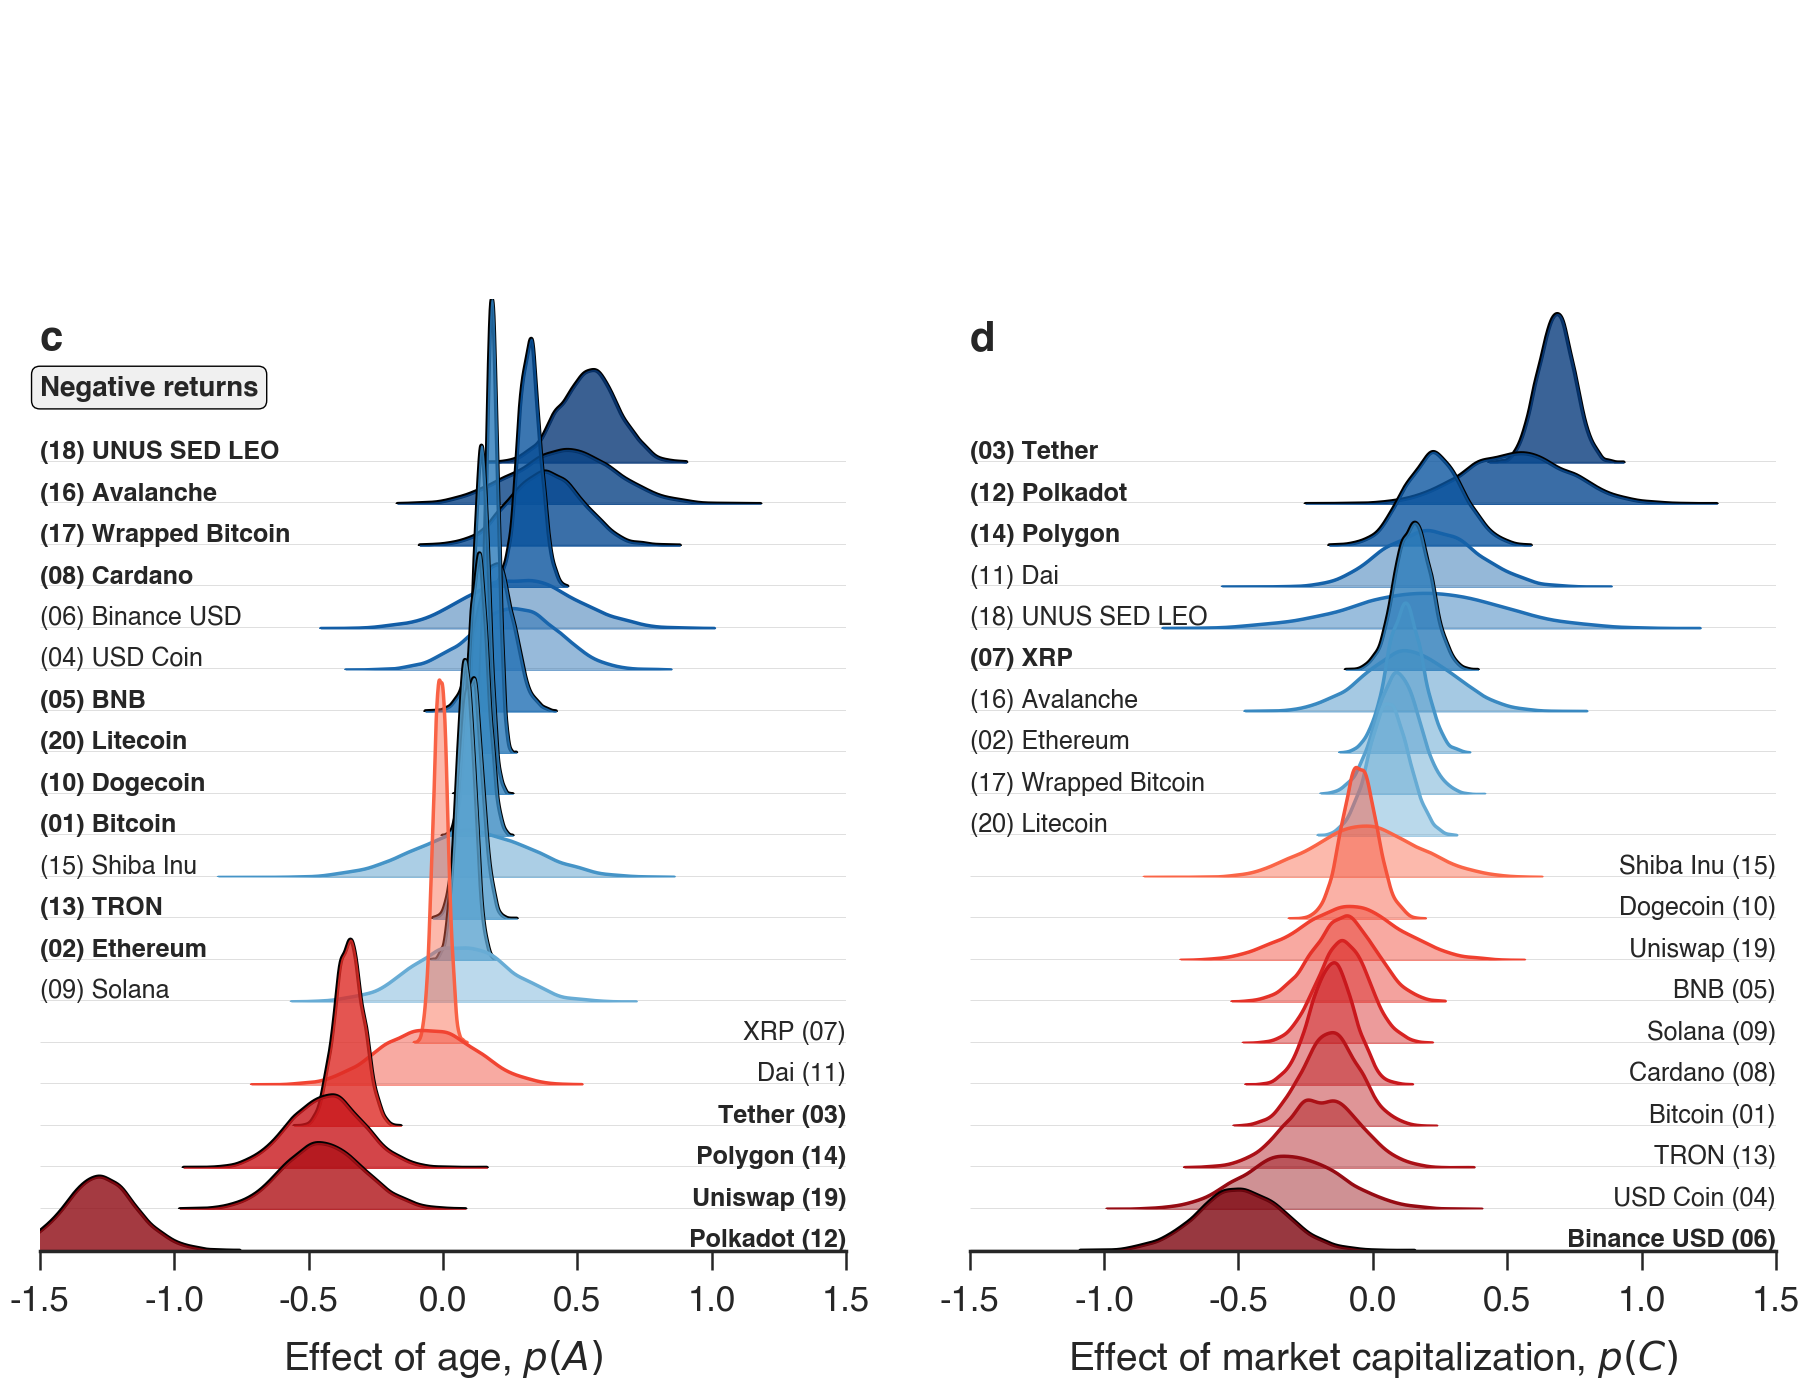

In [12]:
start_, end_, freq_, top_ = 1, 0, 3000, 20
names_list                = negnames
coins                     = np.concatenate((np.asarray(names_list)[::freq_][start_:], names_list[:top_]))
greyalpha, coloralpha     = .35, .45

f, ax  = plt.subplots(nrows=len(coins[:len(coins)-end_]), sharex=True, sharey=True, ncols=2, figsize=stdfigsize(nrows=2, ncols=2))
bx, ax = ax.T

for kde_, zx_, label_, significant_, means_ in zip([kde_neg_cap_time_b, kde_neg_cap_time_c], [ax, bx], [r'Effect of market capitalization, $p(C)$', r'Effect of age, $p(A)$'],
                                           [Bsigcaptime, Csigcaptime], [summary_trace_neg_cap_time[Bmaskcaptime]['mean'].values, summary_trace_neg_cap_time[Cmaskcaptime]['mean'].values]
                                          ):      

    xsamp, ysamp, negcoins, significant_bools, sampled_means = KDE_organised_significant(kde_, names=names_list, freq=freq_, start=start_, end=end_, top=top_, significance=significant_, means=means_)
    nposcolors                                            = len(sampled_means[sampled_means>0]) + len(sampled_means[sampled_means>0])%2
    nnegcolors                                            = len(sampled_means[sampled_means<0]) + len(sampled_means[sampled_means<0])%2
    colors                                                = sns.color_palette('Blues', 4*nposcolors)[-(4*nposcolors)//2::2][::-1] + sns.color_palette('Reds', 4*nnegcolors)[-(4*nnegcolors)//2::2]
    
    for ax_, x_, y_, c_, coin_, sig_, m_, rank_ in zip(zx_, xsamp, ysamp, colors, negcoins, significant_bools, sampled_means, all_goodness_clean.set_index('coin').loc[negcoins].groupby('coin').first().loc[negcoins]['rank'].values+1): 
        if not sig_:
            ax_.plot(x_, y_, '-', color=c_, linewidth=2.5, alpha=1, zorder=1)
            ax_.fill_between(x_, y_, color=c_, alpha=coloralpha, zorder=1)
            ax_.hlines(0.07, -1.5, 1.5, linestyle='-', color='#696969', linewidth=.5, zorder=-10, alpha=.3)
            
            if m_>=0:
                ax_.annotate(f'({rank_:02}) ' + f"{coin_}", xy= (-.0,0.01), xycoords='axes fraction', fontsize=18) #if the effect is significant we add an "*"
            else:
                ax_.annotate(f"{coin_}"+f' ({rank_:02})', xy=(1,0.01), ha='right', xycoords='axes fraction', fontsize=18) #if the effect is significant we add an "*"
            ax_.set_ylim(0, ysamp.max())
            ax_.axis('off')
        else:
            ax_.plot(x_, y_, '-', color='black', alpha=1, zorder=1)
            ax_.fill_between(x_, y_, color=c_, alpha=0.8, zorder=1)
            ax_.hlines(0.07, -1.5, 1.5, linestyle='-', color='#696969', linewidth=.5, zorder=-10, alpha=.3)
            
            if m_>=0:
                ax_.annotate(f'({rank_:02}) ' + f"{coin_}", xy= (-0.0,0.01), xycoords='axes fraction', weight='bold', fontsize=18)
            else:
                ax_.annotate(f"{coin_}"+f' ({rank_:02})', xy= (1,0.01), ha='right', xycoords='axes fraction', weight='bold', fontsize=18)
            ax_.set_ylim(0, ysamp.max())
            ax_.axis('off')


    zx_[-1].axis('on')
    zx_[-1].spines['left'].set_visible(False)
    zx_[-1].tick_params(left=False, bottom=True, labelleft=False)
    zx_[-1].set_xlabel(label_)
    zx_[-1].patch.set_alpha(0.0)
    zx_[-1].set_xlim(-1.5, 1.5)
    zx_[-1].set_xticks(np.arange(-1.5, 1.51,.5))
    zx_[-1].set_xticklabels(np.arange(-1.5, 1.51,.5))

for i, ax_ in zip(range(2), [bx, ax]):
    ax_[0].annotate(string.ascii_lowercase[i+2], (0, 0.25), xycoords='axes fraction', weight='bold', fontsize=30)

bx[0].annotate(r"Negative returns" , (0., 0.15), xycoords='axes fraction', fontsize=20, weight='bold', ha='left',
               bbox={'boxstyle': 'round', 'fc': '#f0f0f0', 'ec': 'black', 'alpha': 1 }
              )

f.tight_layout(h_pad=-30, w_pad=5)    
f.savefig('../final-figures/main/joy_plot_negative.pdf', bbox_inches='tight', dpi=300)

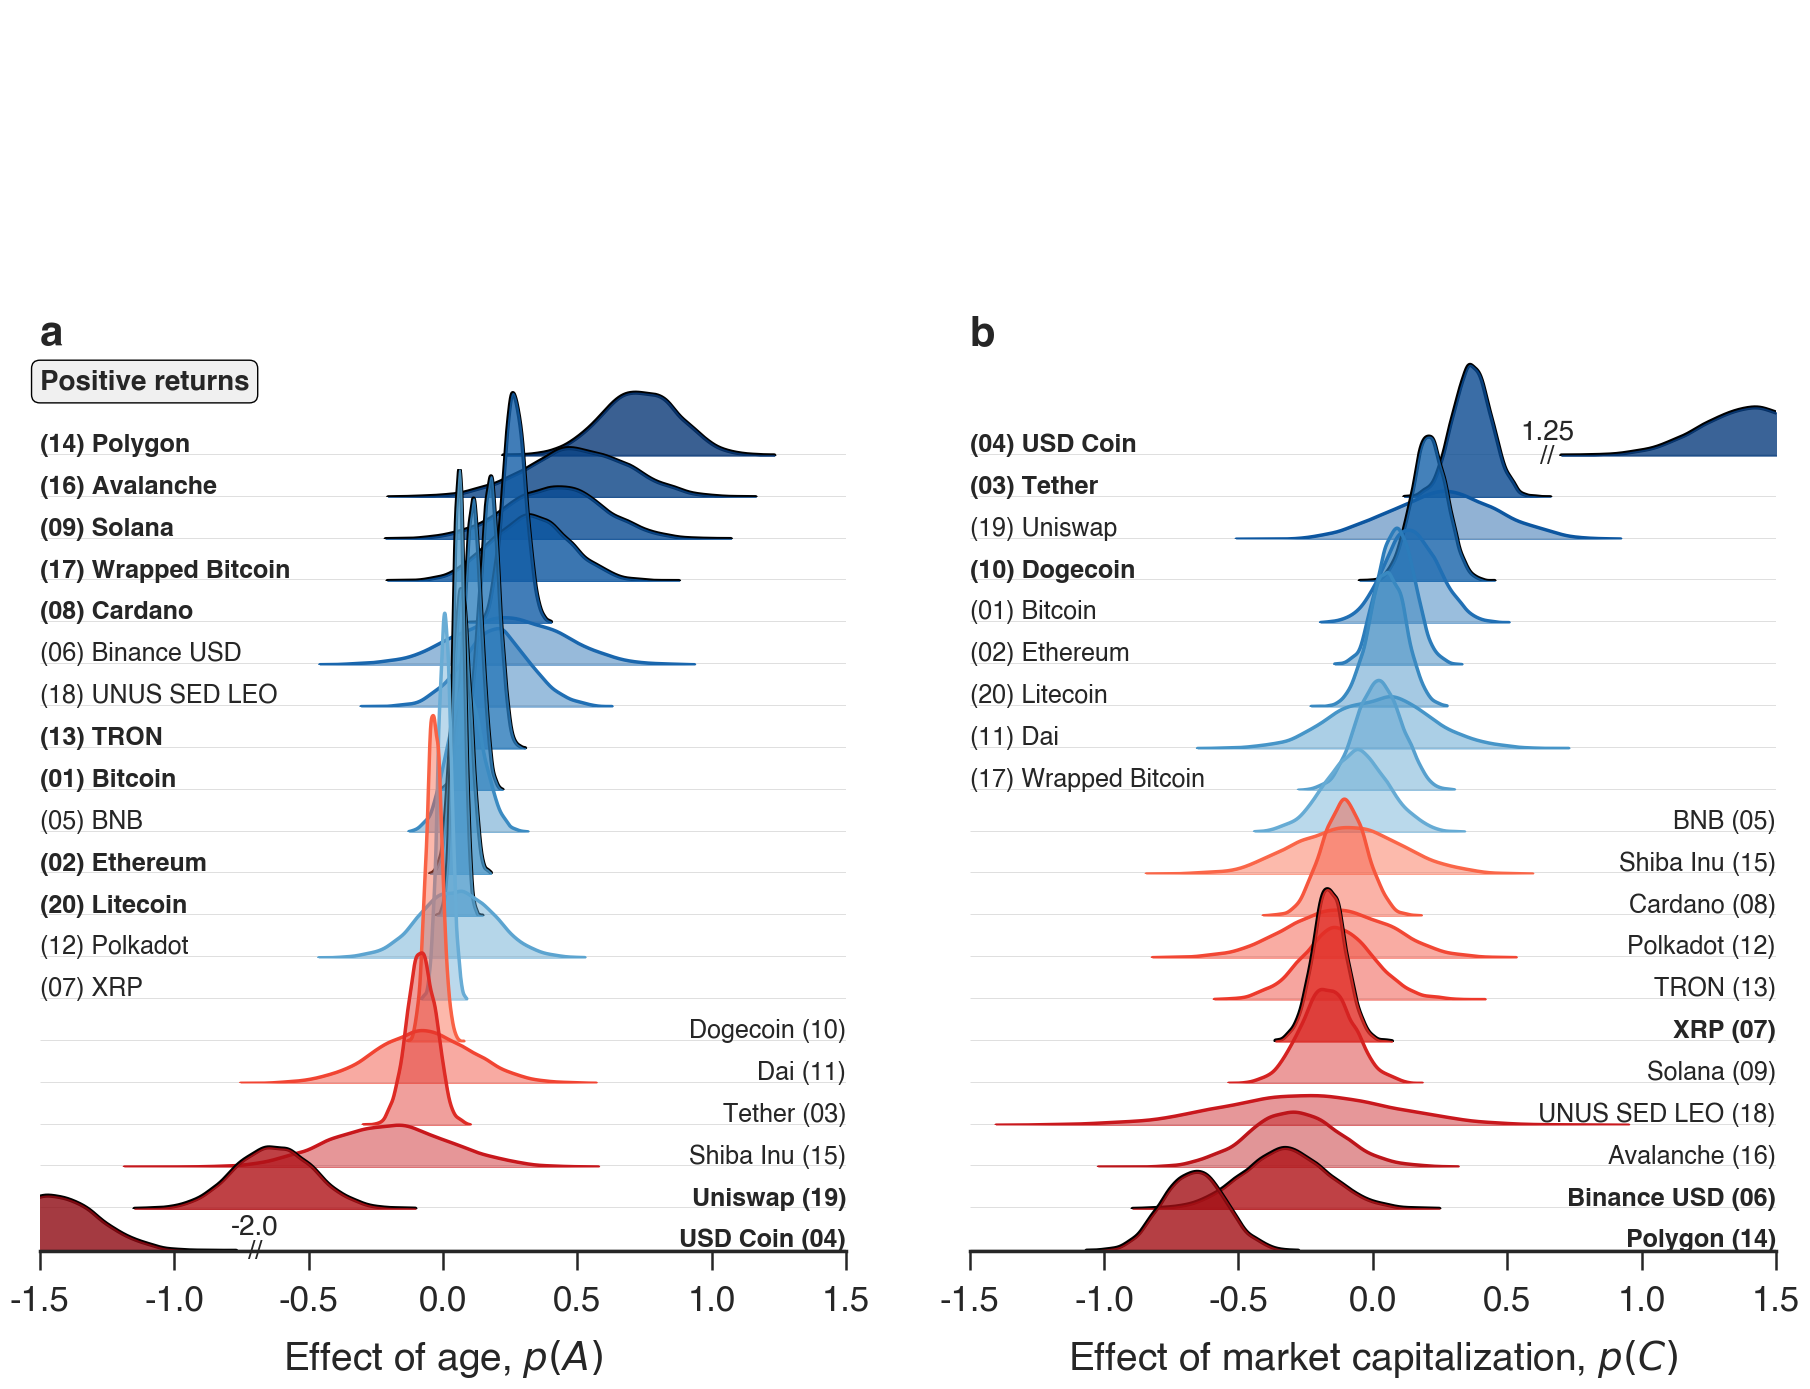

In [13]:
start_, end_, freq_, top_ = 1, 0, 3000, 20
names_list                = posnames
coins                     = np.concatenate((np.asarray(names_list)[::freq_][start_:], names_list[:top_]))
greyalpha, coloralpha     = .35, .45

f, ax  = plt.subplots(nrows=len(coins[:len(coins)-end_]), sharex=True, sharey=True, ncols=2, figsize=stdfigsize(nrows=2, ncols=2))
bx, ax = ax.T

for kde_, zx_, label_, significant_, means_ in zip([kde_pos_cap_time_b, kde_pos_cap_time_c], [ax, bx], [r'Effect of market capitalization, $p(C)$', r'Effect of age, $p(A)$'],
                                                   [Bpossigcaptime, Cpossigcaptime], [summary_trace_pos_cap_time[Bposmaskcaptime]['mean'].values, summary_trace_pos_cap_time[Cposmaskcaptime]['mean'].values]
                                                  ):

    xsamp, ysamp, poscoins, significant_bools, means_sampled = KDE_organised_significant(kde_, names=names_list, freq=freq_, start=start_, end=end_, top=top_, significance=significant_, means=means_)
    nposcolors                                            = len(means_sampled[means_sampled>0]) + len(means_sampled[means_sampled>0])%2
    nnegcolors                                            = len(means_sampled[means_sampled<0]) + len(means_sampled[means_sampled<0])%2
    colors                                                = sns.color_palette('Blues', 4*nposcolors)[-(4*nposcolors)//2::2][::-1] + sns.color_palette('Reds', 4*nnegcolors)[-(4*nnegcolors)//2::2]
    

    for ax_, x_, y_, c_, coin_, sig_, m_, rank_ in zip(zx_, xsamp, ysamp, colors, poscoins, significant_bools, means_sampled, all_goodness_clean.set_index('coin').loc[poscoins].groupby('coin').first().loc[poscoins]['rank'].values+1): 
        if coin_ == 'USD Coin' and m_>0:
            x_ = x_ - 0.6
            ax_.annotate('//',xy=(0.65,0),va='center',ha='center',fontsize=18)
            ax_.annotate('1.25',xy=(0.65,1),va='center',ha='center',fontsize=20)
        elif coin_ == 'USD Coin' and m_<0:
            x_ = x_ + 1.3
            ax_.annotate('//', xy=(-0.7,0),va='center',ha='center',fontsize=18)
            ax_.annotate('-2.0', xy=(-0.7,1),va='center',ha='center',fontsize=20)
        else:pass
            
        if not sig_:
            ax_.plot(x_, y_, '-', color=c_, linewidth=2.5, alpha=1, zorder=1)
            ax_.fill_between(x_, y_, color=c_, alpha=coloralpha, zorder=1)
            ax_.hlines(0.07, -1.5, 1.5, linestyle='-', color='#696969', linewidth=.5, zorder=-10, alpha=.3)
            
            if m_>=0:
                ax_.annotate(f'({rank_:02}) ' + f"{coin_}", xy= (-.0,0.01), xycoords='axes fraction', fontsize=18) #if the effect is significant we add an "*"
            else:
                ax_.annotate(f"{coin_}" + f' ({rank_:02})', xy=(1,0.01), ha='right', xycoords='axes fraction', fontsize=18) #if the effect is significant we add an "*"
            ax_.set_ylim(0, ysamp.max())
            ax_.axis('off')
        else:
            ax_.plot(x_, y_, '-', color='black', alpha=1, zorder=1)
            ax_.fill_between(x_, y_, color=c_, alpha=0.8, zorder=1)
            ax_.hlines(0.07, -1.5, 1.5, linestyle='-', color='#696969', linewidth=.5, zorder=-10, alpha=.3)
            
            if m_>=0:
                ax_.annotate(f'({rank_:02}) ' + f"{coin_}", xy= (-0.0,0.01), xycoords='axes fraction', weight='bold', fontsize=18)
            else:
                ax_.annotate(f"{coin_}" + f' ({rank_:02})', xy= (1,0.01), ha='right', xycoords='axes fraction', weight='bold', fontsize=18)
            ax_.set_ylim(0, ysamp.max())
            ax_.axis('off')

    zx_[-1].axis('on')
    zx_[-1].spines['left'].set_visible(False)
    zx_[-1].tick_params(left=False, bottom=True, labelleft=False)
    zx_[-1].set_xlabel(label_)
    zx_[-1].patch.set_alpha(0.0)
    zx_[-1].set_xlim(-1.5, 1.5)
    zx_[-1].set_xticks(np.arange(-1.5, 1.51,.5))
    zx_[-1].set_xticklabels(np.arange(-1.5, 1.51,.5))

for i, ax_ in zip(range(2), [bx, ax]):
    ax_[0].annotate(string.ascii_lowercase[i], (0, 0.25), xycoords='axes fraction', weight='bold', fontsize=30)

bx[0].annotate(r"Positive returns" , (0, 0.15), xycoords='axes fraction', fontsize=20, weight='bold', ha='left',
               bbox={'boxstyle': 'round', 'fc': '#f0f0f0', 'ec': 'black', 'alpha': 1 }
              )

f.tight_layout(h_pad=-30, w_pad=5)    
f.savefig('../final-figures/main/joy_plot_positive.pdf', bbox_inches='tight', dpi=300)

# <span style="font-family:calibri; font-weight:bold; font-size:1.4em;">Supplementary Figure S10</span><a class="anchor" id="s10"></a>

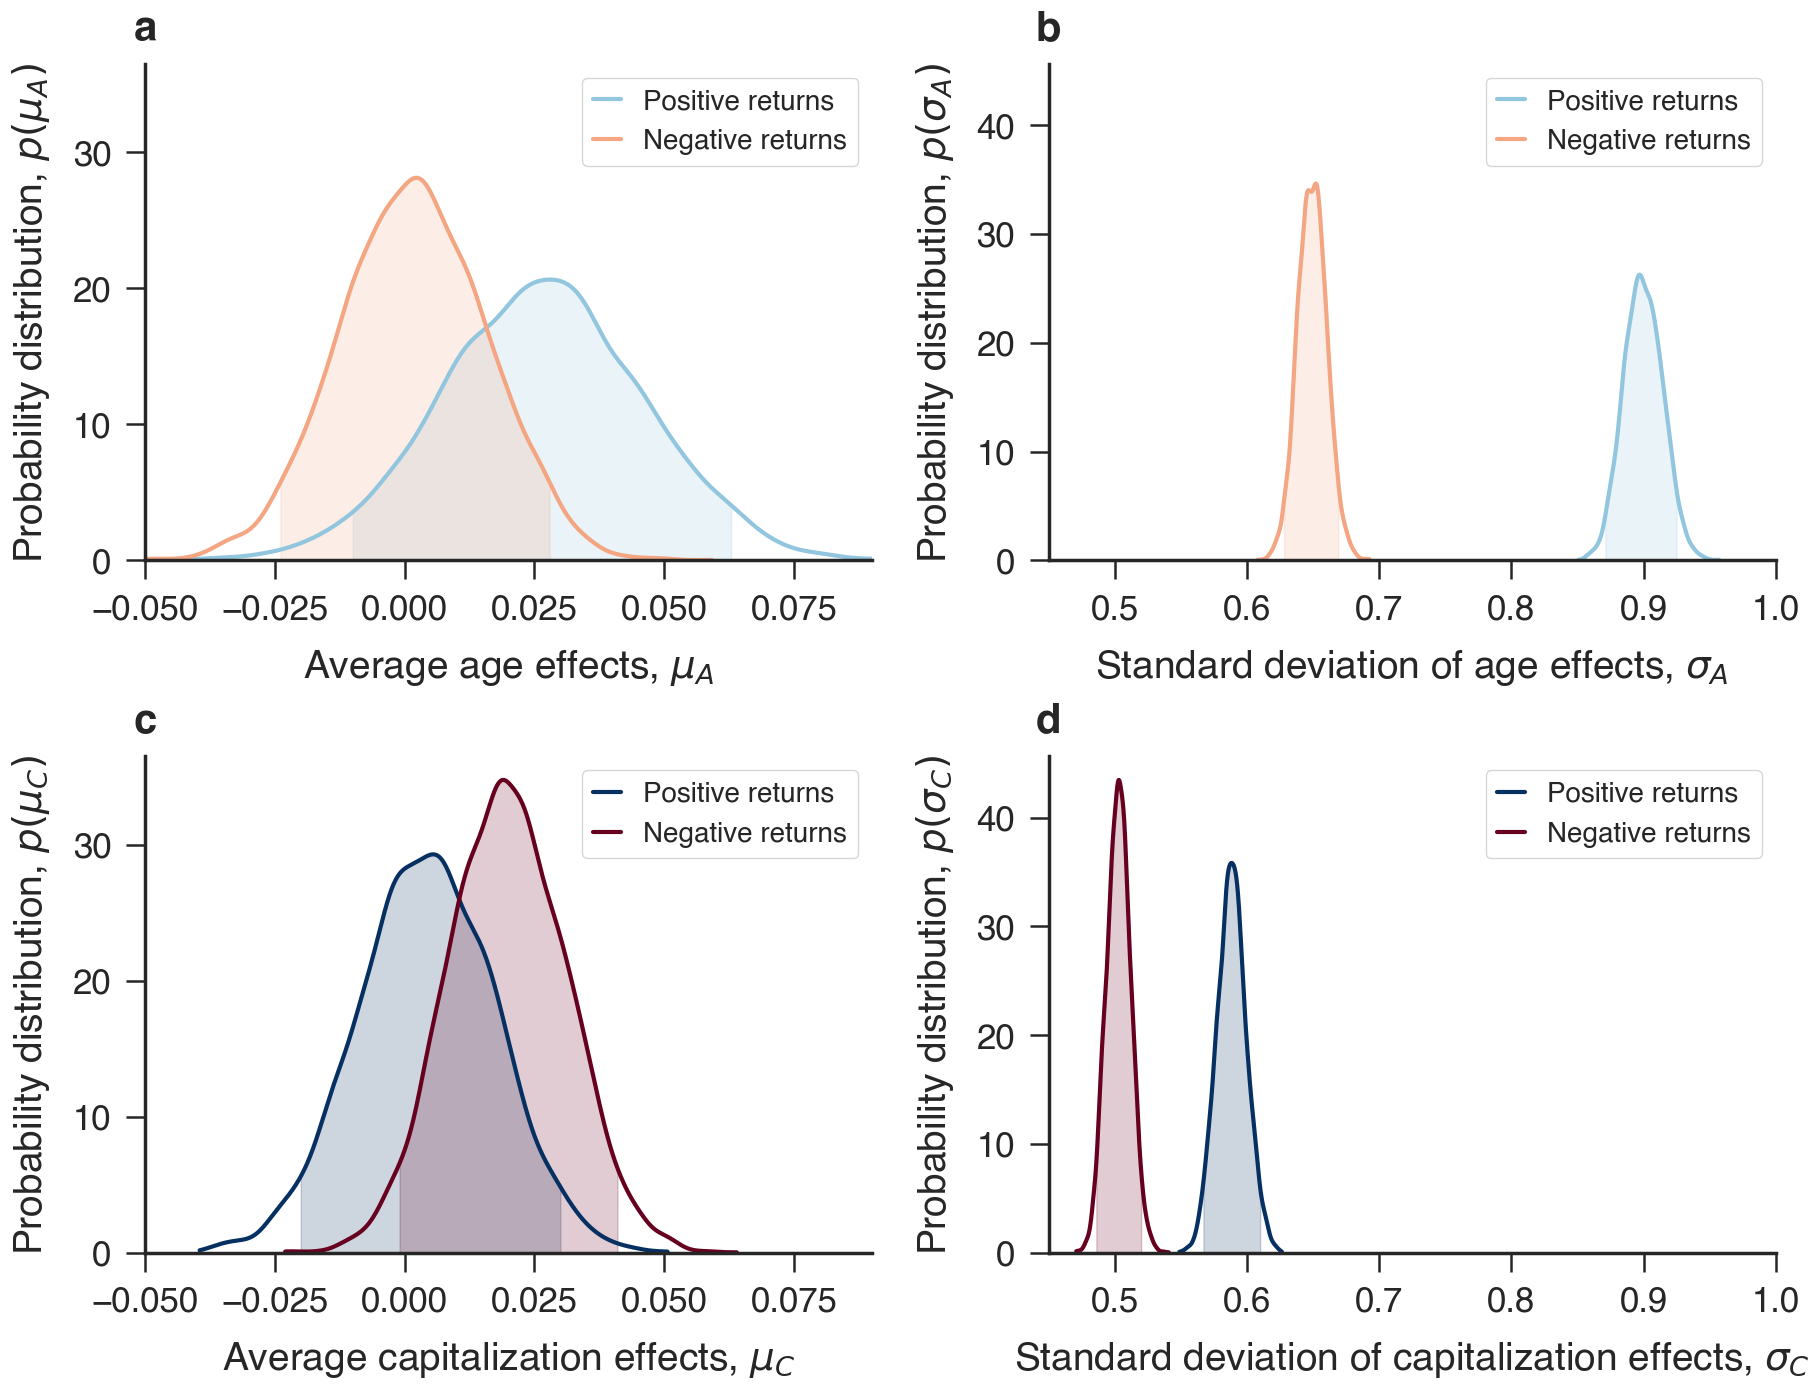

In [14]:
#LOADING
positive_trace = az.from_netcdf('data/trace_no_positive_tail_with_time.nc')
negative_trace = az.from_netcdf('data/trace_no_negative_tail_with_time.nc')

cmuxneg, cmuyneg, _, _          = KDE_function(np.concatenate(negative_trace.posterior.mu_b.values))
cmuneg_lower3, cmuneg_upper97   = summary_trace_neg_cap_time.loc['mu_b']['hdi_3%'], summary_trace_neg_cap_time.loc['mu_b']['hdi_97%']

csdxneg, csdyneg, _, _          = KDE_function(np.concatenate(negative_trace.posterior.sigma_b.values))
csdneg_lower3, csdneg_upper97   = summary_trace_neg_cap_time.loc['sigma_b']['hdi_3%'], summary_trace_neg_cap_time.loc['sigma_b']['hdi_97%']

cmuxpos, cmuypos, _, _          = KDE_function(np.concatenate(positive_trace.posterior.mu_b.values))
cmupos_lower3, cmupos_upper97   = summary_trace_pos_cap_time.loc['mu_b']['hdi_3%'], summary_trace_pos_cap_time.loc['mu_b']['hdi_97%']

csdxpos, csdypos, _, _          = KDE_function(np.concatenate(positive_trace.posterior.sigma_b.values))
csdpos_lower3, csdpos_upper97   = summary_trace_pos_cap_time.loc['sigma_b']['hdi_3%'], summary_trace_pos_cap_time.loc['sigma_b']['hdi_97%']



Tmuxneg, Tmuyneg, _, _          = KDE_function(np.concatenate(negative_trace.posterior.mu_c.values))
Tmuneg_lower3, Tmuneg_upper97   = summary_trace_neg_cap_time.loc['mu_c']['hdi_3%'], summary_trace_neg_cap_time.loc['mu_c']['hdi_97%']

Tsdxneg, Tsdyneg, _, _          = KDE_function(np.concatenate(negative_trace.posterior.sigma_c.values))
Tsdneg_lower3, Tsdneg_upper97   = summary_trace_neg_cap_time.loc['sigma_c']['hdi_3%'], summary_trace_neg_cap_time.loc['sigma_c']['hdi_97%']

Tmuxpos, Tmuypos, _, _          = KDE_function(np.concatenate(positive_trace.posterior.mu_c.values))
Tmupos_lower3, Tmupos_upper97   = summary_trace_pos_cap_time.loc['mu_c']['hdi_3%'], summary_trace_pos_cap_time.loc['mu_c']['hdi_97%']

Tsdxpos, Tsdypos, _, _          = KDE_function(np.concatenate(positive_trace.posterior.sigma_c.values))
Tsdpos_lower3, Tsdpos_upper97   = summary_trace_pos_cap_time.loc['sigma_c']['hdi_3%'], summary_trace_pos_cap_time.loc['sigma_c']['hdi_97%']


mu_data     = [[Tmuxpos, Tmuypos], [Tmuxneg, Tmuyneg]], [[cmuxpos, cmuypos], [cmuxneg, cmuyneg]]
mu_hdi_data = [[Tmupos_lower3, Tmupos_upper97], [Tmuneg_lower3, Tmuneg_upper97]], [[cmupos_lower3, cmupos_upper97], [cmuneg_lower3, cmuneg_upper97]]

sd_data     = [[Tsdxpos, Tsdypos], [Tsdxneg, Tsdyneg]], [[csdxpos, csdypos], [csdxneg, csdyneg]]
sd_hdi_data = [[Tsdpos_lower3, Tsdpos_upper97], [Tsdneg_lower3, Tsdneg_upper97]], [[csdpos_lower3, csdpos_upper97], [csdneg_lower3, csdneg_upper97]]

# legends = [['Market capitalization', 'Age']]*2
legends     = [['$\mu_A^{+}$', '$\mu_A^{-}$'], ['$\mu_C^{+}$', '$\mu_C^{-}$']]
sec_legends = [['Positive returns', 'Negative returns']]*2



# PLOTTING ###############################################################################
f, ax  = plt.subplots(nrows=2, ncols=2, figsize=stdfigsize(nrows=2, ncols=2))
ax, bx = ax.T

for ax_, bx_, mu_data_, mu_hdi_data_, sd_data_, sd_hdi_data_, i, colors_, sec_legends_, \
    mu_, sigma_, longmu_, longsigma_, xl_ in zip(ax, bx, mu_data, mu_hdi_data, 
                                                 sd_data, sd_hdi_data, range(2), [['#92c5de', '#f4a582'], ['#053061', '#67001f']], 
                                                 sec_legends,['\mu_A', '\mu_C'], ['\sigma_A', '\sigma_C'], [', $\mu_A$', ', $\mu_C$'], 
                                                 [', $\sigma_A$', ', $\sigma_C$'], ['age', 'capitalization']
                                                ):
    
    posleg_, negleg_                 = sec_legends_
    poscolor, negcolor               = colors_
    (xmu_, ymu_), (xmuneg_, ymuneg_) = mu_data_
    (pos_muhdilow_, pos_muhdiup_),\
    (neg_muhdilow_, neg_muhdiup_)    = mu_hdi_data_
    (xsd_, ysd_), (xsdneg_, ysdneg_) = sd_data_
    (pos_sdhdilow_, pos_sdhdiup_),\
    (neg_sdhdilow_, neg_sdhdiup_)    = sd_hdi_data_
    
    
    ax_.plot(xmu_, ymu_, color=poscolor, label=posleg_)    
    ax_.fill_between(xmu_[(xmu_>=pos_muhdilow_) & (xmu_<=pos_muhdiup_)], ymu_[(xmu_>=pos_muhdilow_) & (xmu_<=pos_muhdiup_)], color=poscolor, alpha=.2)
    ax_.plot(xmuneg_, ymuneg_, color=negcolor, label=negleg_)    
    ax_.fill_between(xmuneg_[(xmuneg_>=neg_muhdilow_) & (xmuneg_<=neg_muhdiup_)], ymuneg_[(xmuneg_>=neg_muhdilow_) & (xmuneg_<=neg_muhdiup_)], color=negcolor, alpha=.2)
    
    ax_.set_ylabel('Probability distribution, $p({})$'.format(mu_))
    ax_.set_xlabel('Average {} effects{}'.format(xl_, longmu_)) 
    ax_.set_ylim(0,)
    ax_.set_xlim(-0.05, 0.09)
    ax_.legend(handlelength=1.)
    
    
    bx_.plot(xsd_, ysd_, color=poscolor, label=posleg_)    
    bx_.fill_between(xsd_[(xsd_>=pos_sdhdilow_) & (xsd_<=pos_sdhdiup_)], ysd_[(xsd_>=pos_sdhdilow_) & (xsd_<=pos_sdhdiup_)], color=poscolor, alpha=.2)
    bx_.plot(xsdneg_, ysdneg_, color=negcolor, label=negleg_)    
    bx_.fill_between(xsdneg_[(xsdneg_>=neg_sdhdilow_) & (xsdneg_<=neg_sdhdiup_)], ysdneg_[(xsdneg_>=neg_sdhdilow_) & (xsdneg_<=neg_sdhdiup_)], color=negcolor, alpha=.2)
    
    bx_.set_ylabel('Probability distribution, $p({})$'.format(sigma_)) 
    bx_.set_xlabel('Standard deviation of {} effects{}'.format(xl_, longsigma_)) 
    bx_.set_ylim(0,)
    bx_.set_xlim(0.45, 1.)
    bx_.legend(handlelength=1.)
    
ax[0].sharey(ax[1])
bx[0].sharey(bx[1])

for i, ax_, bx_ in zip(range(len(ax)), ax, bx):
    ax_.annotate(string.ascii_lowercase[2*i], (0, 1.07), xycoords='axes fraction', va='center', ha='center', weight='bold', fontsize=30)
    bx_.annotate(string.ascii_lowercase[2*i+1], (0, 1.07), xycoords='axes fraction', va='center', ha='center', weight='bold', fontsize=30)
    
f.tight_layout(w_pad=3)
f.savefig('../final-figures/supplementary/figS10.pdf', bbox_inches='tight')